<hr>
<h1><center>Web Traffic Forecasting : ML Modeling</center></h1>
<hr>

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb

### Loading of Actual Train Data

In [4]:
complete_train = pd.read_csv('./train_2.csv')

complete_train['Site']      = complete_train['Page'].map(lambda x:x.split('_')[-3])
complete_train['Site_Name'] = complete_train['Site'].map(lambda x:x.split('.')[1])
complete_train['Language']  = complete_train['Site'].map(lambda x:x.split('.')[0])
complete_train['Access']    = complete_train['Page'].map(lambda x:x.split('_')[-2])
complete_train['Agent']     = complete_train['Page'].map(lambda x:x.split('_')[-1])

from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

complete_train['Site_OHE'] = label.fit_transform(complete_train['Site_Name']).tolist()
print("Site Encoded using     : ", label.classes_)

complete_train['Lang_OHE'] = label.fit_transform(complete_train['Language']).tolist()
print("Language Encoded using : ", label.classes_)

complete_train['Access_OHE'] = label.fit_transform(complete_train['Access']).tolist()
print("Access Encoded using   : ", label.classes_)

complete_train['Agent_OHE'] = label.fit_transform(complete_train['Agent']).tolist()
print("Agent Encoded using    : ", label.classes_)

complete_train.drop(['Site', 'Site_Name', 'Language', 'Access', 'Agent'], axis=1, inplace=True)
complete_train = complete_train.fillna(0)
#complete_train.to_csv('./Transformed_train_2.csv', index=False)


#test_dates
from datetime import date, timedelta

#end of the train is Sep 20, 2017 and data to e
start = date(2017,9,11)
end   = date(2017,11,13)

no_days = end - start

test_days = [ (start+timedelta(days=x)).strftime('%Y-%m-%d') for x in range(no_days.days+1) ]
print("\n\nTest Data to run from {0} upto {1}".format(test_days[0], test_days[-1]))

Site Encoded using     :  ['mediawiki' 'wikimedia' 'wikipedia']
Language Encoded using :  ['commons' 'de' 'en' 'es' 'fr' 'ja' 'ru' 'www' 'zh']
Access Encoded using   :  ['all-access' 'desktop' 'mobile-web']
Agent Encoded using    :  ['all-agents' 'spider']


Test Data to run from 2017-09-11 upto 2017-11-13


### Loading Page-Key File

In [5]:
page_key = pd.read_csv('./key_2.csv')
page_key.head()

,Page,Id
0,007_スペクター_ja.wikipedia.org_all-access_all-agen...,0b293039387a
1,007_スペクター_ja.wikipedia.org_all-access_all-agen...,7114389dd824
2,007_スペクター_ja.wikipedia.org_all-access_all-agen...,057b02ff1f09
3,007_スペクター_ja.wikipedia.org_all-access_all-agen...,bd2aca21caa3
4,007_スペクター_ja.wikipedia.org_all-access_all-agen...,c0effb42cdd5


### Loading Train Data

In [6]:
train = pd.read_csv('./train_data.csv')
test  = pd.read_csv('./test_data.csv')
#train = train.iloc[:,1:]
train.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,...,2017-05-25,2017-05-26,2017-05-27,2017-05-28,2017-05-29,2017-05-30,2017-05-31,2017-06-01,2017-06-02,2017-06-03,2017-06-04,2017-06-05,2017-06-06,2017-06-07,2017-06-08,2017-06-09,2017-06-10,2017-06-11,2017-06-12,2017-06-13,2017-06-14,2017-06-15,2017-06-16,2017-06-17,2017-06-18,2017-06-19,2017-06-20,2017-06-21,2017-06-22,2017-06-23,2017-06-24,2017-06-25,2017-06-26,2017-06-27,2017-06-28,Observed,Site_OHE,Lang_OHE,Access_OHE,Agent_OHE
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,10.0,...,15.0,40.0,22.0,18.0,29.0,19.0,16.0,37.0,57.0,30.0,35.0,25.0,30.0,28.0,18.0,23.0,37.0,23.0,27.0,24.0,26.0,35.0,32.0,29.0,38.0,46.0,22.0,28.0,26.0,29.0,21.0,23.0,23.0,32.0,34.0,21.0,2,8,0,1
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,12.0,...,17.0,40.0,28.0,20.0,25.0,21.0,28.0,39.0,29.0,31.0,41.0,21.0,23.0,22.0,19.0,20.0,30.0,34.0,14.0,22.0,26.0,18.0,21.0,25.0,17.0,15.0,10.0,17.0,24.0,18.0,193.0,26.0,62.0,127.0,104.0,20.0,2,8,0,1
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,4.0,...,4.0,2.0,2.0,10.0,6.0,1.0,4.0,5.0,1.0,4.0,4.0,2.0,3.0,1.0,2.0,0.0,6.0,3.0,3.0,11.0,19.0,11.0,5.0,3.0,6.0,3.0,3.0,8.0,7.0,3.0,5.0,4.0,4.0,5.0,5.0,0.0,2,8,0,1
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,8.0,...,14.0,8.0,14.0,22.0,17.0,16.0,13.0,24.0,14.0,14.0,9.0,12.0,10.0,12.0,17.0,5.0,15.0,10.0,12.0,16.0,17.0,8.0,10.0,18.0,19.0,13.0,26.0,12.0,17.0,15.0,12.0,11.0,12.0,10.0,22.0,21.0,2,8,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,14.0,23.0,25.0,8.0,19.0,7.0,25.0,16.0,12.0,13.0,30.0,13.0,12.0,7.0,13.0,22.0,16.0,14.0,18.0,6.0,9.0,38.0,17.0,17.0,10.0,8.0,12.0,12.0,17.0,16.0,12.0,10.0,21.0,14.0,9.0,2,8,0,1


In [7]:
non_date_cols = [ x for x in train.columns.tolist() if x.endswith('OHE') ]
date_cols     = [ x for x in train.columns.tolist() if not x.endswith('OHE') ]

In [8]:
observed   = train['Observed']

pagename_X = train[non_date_cols]
#pagename_X_tr = StandardScaler().fit_transform()
timeseries_X = train[date_cols].drop('Observed', axis=1)

pagename_X_te = test[non_date_cols]


In [9]:
from sklearn.preprocessing import StandardScaler
std_sclr      = StandardScaler()
X_pagename    = std_sclr.fit_transform(pagename_X)
X_pagename_te = std_sclr.transform(pagename_X_te)

#### Metric for Evaluation

\begin{equation*}
SMAPE = \frac {200\%}{n} \sum_{t=1}^n\frac {\lvert{F}_t-{A}_t\rvert} {(\lvert{A}_t\rvert+\lvert{F}_t\rvert)}
\end{equation*}

<h5>Points to remember : </h5>
<p>From EDA, we observed that current pageview of the page is highly correlated to that of lagged values.</p>
<p>We will compare model with the Lagged pageviews to forecast the future values.</p>
<p>With the classical hyper-parameters of the ML models, we can also say that [lagged_window] is also an Hyper-parameter determining the performance of the models.</p>
<p>Also, we want our model to penalize the small deviation from the actual value of pageview and hence, we will take the log of values for the model prediction. Later, this values will be converted back to actual pageviews to get the forecasted pageview on Test data</p>

#### Metrics and Parameters

In [10]:
alpha_range   = [ 10**x for x in range(-5,4) ]
#lagged_window = list(range(7, 366, 7))
lagged_window = [ 7, 30, 90, 365 ]
train_last    = '2017-06-29'

def smape(ytr, ypr):
    """
    function which takes Y_True and Y_Predicted as input and 
    returns SMAPE for the values as per above mentioned formula
    """
    numerator   = np.abs(ypr - ytr)
    #print(numerator)
    denominator = (np.abs(ytr) + np.abs(ypr))
    #print(denominator)
    return (200/len(ytr) * np.sum( numerator / denominator ))

def smoothed_smape(ytr, ypr):
    """
    function returns SMAPE for the Y_True and Y_Pred values
    For 0 values of T_True, smoothing has been done.
    """
    ytr += np.log1p(0.00001)
    numerator   = np.abs(ypr - ytr)
    #print(numerator)
    denominator = (np.abs(ytr) + np.abs(ypr))
    #print(denominator)
    return (200/len(ytr) * np.sum( numerator / denominator ))

def mape(ytr, ypr, alpha=0.0001):
    """
    Function returns MAPE of Y_True and Y_Pred.
    Smoothing can be done by adding small values of Alpha to avoid Zero Division
    in case of 0 paeviews in Y_True
    """
    #ytr = np.ceil(np.expm1(ytr))
    #ypr = np.ceil(np.expm1(ypr))
    ytr += alpha
    abs_err      = np.abs((ytr - ypr) / ytr)
    #print(abs_err)
    mean_abs_perr = np.mean(abs_err)*100
    return mean_abs_perr

def rmse(ytr, ypr):
    """
    Functon returns the RMSE of Y_True and Y_Pred
    """
    from math import sqrt
    from sklearn.metrics import mean_squared_error
    return sqrt(mean_squared_error(ytr, ypr))

In [11]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error

In [ ]:
models = dict()

# [1] Modeling

## [1.1] Window Mean

<p><li>Considering a window of records, we will consider Mean of values as a forecasted value for test data</li></p>

#### [1.1.1] Hyper-Parameter Tuning : Lagged Window

In [ ]:
Y = np.log1p(observed.values)


error = list()
for lag in lagged_window:
    #print("Lag=",lag)
    X = np.log1p(timeseries_X.iloc[:,-lag:])
    #X = np.hstack((X_pagename, X))
    mean_X = X.mean(axis=1)
    #print("Lag=",lag,"     Start Date : ",X.columns.tolist()[0],"     End Date :",X.columns.tolist()[-1])
    #calculating SMAPE and MAPE
    train_smape = smoothed_smape(Y, mean_X)
    train_mape  = mape(Y, mean_X)
    #print("Lag=",lag,"     SMAPE=",train_smape)#,"     RMSE=",train_rmse, "     MAPE", train_mape)
    error.append(train_smape)
index = np.argmin(error)
best_window=lagged_window[index];min_smape=error[index]
error.append([best_window, min_smape])
best_smape = error[index]

print("Best parameters : \nLagged Window = {0}, \nMIN SMAPE = {1}"\
      .format(best_window, best_smape))

Best parameters : 
Lagged Window = 7, 
MIN SMAPE = 17.55514034176668


<p>
    With the hyper-parameter tuning, we found : 
    <li>Best Window of <b>7 days</b></li>
</p>

#### [1.1.2] Model Re-Fitting : with Best lagged window

In [ ]:
#keeping an history values for future prediction
history = timeseries_X.iloc[:,-best_window:]

#preparing data for test run
X = np.log1p(history.iloc[:, -best_window:])
#staking it with page features
#X = np.hstack((X_pagename, X))
mean_X = X.mean(axis=1)
#adding prediction of last train column as history column
history[train_last] = mean_X

#### [1.1.3] CV Data Analysis

In [ ]:
test_data = pd.DataFrame()

test_cols = test.columns.tolist()[:-4]
#print(history.shape)
for test_index in range(len(test_cols)):
    #print(history.shape)
    X = np.log1p(history.iloc[:,-best_window:])
    #X_lagged = np.hstack((X_pagename_te, X))
    predicted = np.ceil(np.expm1(X.mean(axis=1)))
    test_data[test_cols[test_index]] = predicted
    history[test_cols[test_index]]   = predicted

test_smape = np.mean(smoothed_smape(test.iloc[:,:-4], test_data))
print("SMAPE on TEST DATA : ",test_smape)
test_rmse  = np.mean(rmse(test.iloc[: ,:-4], test_data))
print("RMSE  on TEST DATA : ",test_rmse)
models['Window Mean'] = [best_window, test_smape, test_rmse]

SMAPE on TEST DATA :  78.26019883931112
RMSE  on TEST DATA :  56034.845217840106


#### [1.1.4] Model Performance : SMAPE on Actual vs. Forecasted values

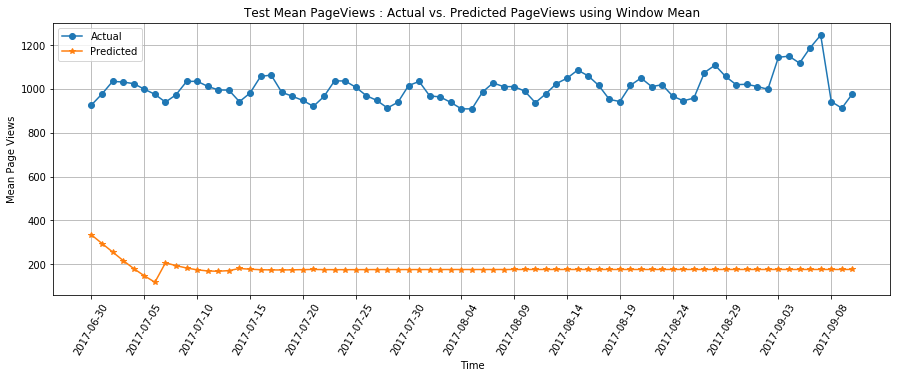

In [ ]:
#plot for mean of actual test and predicted test
plt.figure(figsize=(15, 5))
plt.title('Test Mean PageViews : Actual vs. Predicted PageViews using Window Mean')
actual_mean = test.iloc[:, :-4].mean(axis=0)
pred_mean   = test_data.mean(axis=0)

xtick_labels = [ x for x in enumerate(test_cols) if x[0]%5==0 ]
xtick_loc    = [ x[0] for x in xtick_labels ]
xtick_label  = [ x[1] for x in xtick_labels ]

b1 = plt.plot(actual_mean, marker="o")
b2 = plt.plot(pred_mean, marker="*")
plt.xlabel('Time')
plt.ylabel('Mean Page Views')
plt.grid()
plt.legend([b1[0], b2[0]], ['Actual', 'Predicted'])
plt.xticks(xtick_loc, xtick_label, rotation=60)
plt.show()

<p><li>From above Mean distribution of Actual vs. Predicted Page Views, we can see that for, mean Page Views of test data is constant after certain drops at the start of the data</li></p>
<p><li>This is very simple model which can be trained and hence we can see it Under-fits the given test data</li></p>
<p><li>SMAPE for the same is considerable low on Train data but the same increases for Test data. Model is overfitting for the given data</li></p>

#### [1.5.5] Test Data Analysis 

In [ ]:
#testing with actual data
past_data_cols = complete_train.columns.tolist()[-best_window-4:]
past_data_cols.insert(0, 'Page')

past_data = complete_train[past_data_cols]
#past_data.head()

#getting date columns and non_date columns
date_cols = [ x for x in past_data.columns.tolist() if '-' in x ]
non_date  = [ x for x in past_data.columns.tolist() if x not in date_cols and x != 'Page' ]

#separating the ata into series of PageViews and Site features
pagename_X   = complete_train[non_date]
timeseries_X = complete_train[date_cols]

from sklearn.preprocessing import StandardScaler
#standardize the Site features
std_sclr      = StandardScaler()
X_pagename    = std_sclr.fit_transform(pagename_X)

In [ ]:
model_test = pd.DataFrame()
model_test['Page'] = complete_train.Page.values
#print(past_data.shape)
for test_index in range(len(test_days)):
    #print(history.shape)
    X = np.log1p(timeseries_X.iloc[:,-best_window:])
    #X_lagged = np.hstack((X_pagename_te, X))
    predicted = np.ceil(np.expm1(X.mean(axis=1)))
    model_test[test_days[test_index]] = predicted
    timeseries_X[test_days[test_index]]     = predicted

In [ ]:
f = open('Window_Mean_Page_Count.csv', 'w')
f.write('Page|Visits'+'\n')
for col in model_test.iloc[:,-62:].columns.tolist():
  test_data = model_test[['Page',col]]
  pageviews = [ str(int(x)) for x in test_data.iloc[:,-1] ]
  pagename  = [ x+'_'+test_data.columns.tolist()[-1] for x in test_data.iloc[:,0] ]
  page_view = list(zip(pagename,pageviews))
  #writing it into file
  for line in page_view:
    n, c = line
    f.write(n+'|'+c)
    f.write('\n')
test_data_final = pd.read_csv('./Window_Mean_Page_Count.csv', sep='|')  

#saving the final file
page_key.merge(test_data_final, how='left', on='Page')[['Id', 'Visits']].fillna(0).to_csv('./Test_Data_Window_Mean.csv', index=False)

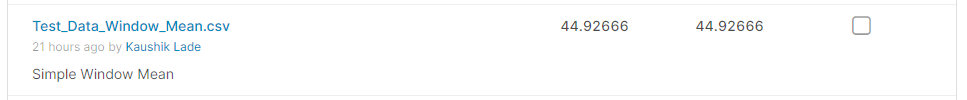

In [ ]:
models['Window Mean'].append('44.9267')

## [1.2] Linear Regression (Squared Loss)

<p>
    <li>Being a Regression problem, we can use Linear Regression with Square Loss for forecast</li>
</p>

#### [1.2.1] Hyper-Parameter Tuning : Lagged Window

In [ ]:
#taking log1p of both values, x_train and y_labels
Y = np.log1p(observed.values)

error = list()
for lag in lagged_window:
    print("**** Running with Lagged Window =",lag)
    X = np.log1p(timeseries_X.iloc[:,-lag:])
    X = np.hstack((X_pagename, X))
    smape_error = list()
    for alpha in alpha_range:  
        #print("Lag=",lag,"     Start Date : ",X.columns.tolist()[0],"     End Date :",X.columns.tolist()[-1])
        #fitting log_reg on lagged data
        log_reg = SGDRegressor(alpha=alpha, loss='squared_loss', penalty='l2', \
                               fit_intercept=True, random_state=45)
        log_reg.fit(X, Y)
        #making prediction for last day of Train
        model_predicted = log_reg.predict(X)
        #calculating SMAPE and MAPE
        train_smape     = smoothed_smape(Y, model_predicted)
        #print("Lag=",lag,"     SMAPE=",train_smape)#,"     RMSE=",train_rmse, "     MAPE", train_mape)
        smape_error.append(train_smape)
    index = np.argmin(smape_error)
    best_alpha=alpha_range[index];min_smape=smape_error[index]
    error.append([best_alpha, min_smape])

index = np.argmin([ x[1] for x in error ])
best_window = lagged_window[index]
best_alpha, best_smape = error[index]
print("Best parameters : \nAlpha = {0}, \nLagged Window = {1}, \nMIN SMAPE = {2}"\
      .format(best_alpha, best_window, best_smape))

**** Running with Lagged Window = 7
**** Running with Lagged Window = 30
**** Running with Lagged Window = 90
**** Running with Lagged Window = 365
Best parameters : 
Alpha = 0.1, 
Lagged Window = 90, 
MIN SMAPE = 16.9803674316663


<p>
    With the Hyper-parameter Tuning of the model, we found :
    <li>Best Window of <b>90 days</b></li>
    <li>Best Alpha to be 0.1</li>
</p>

#### [1.2.2] Model Re-Fitting : with Best lagged window

In [ ]:
#keeping an history values for future prediction
history = timeseries_X.iloc[:,-best_window:]

#preparing data for test run
X = np.log1p(history.iloc[:, -best_window:])
#staking it with page features
X = np.hstack((X_pagename, X))
log_reg = SGDRegressor(alpha=best_alpha, loss='squared_loss', \
                     penalty='l2', fit_intercept=True, random_state=45)
log_reg.fit(X, Y)
#saving the best fit mode
joblib.dump(log_reg, './ML_MODEL-linear_regression_squareloss.sav')

#adding prediction of last train column as history column
history[train_last] = [ np.ceil(np.expm1(x)) for x in log_reg.predict(X) ]

#### [1.2.3] CV Data Analysis

In [ ]:
test_data = pd.DataFrame()
test_cols = test.columns.tolist()[:-4]
#print(history.shape)
for test_index in range(len(test_cols)):
    #print(history.shape)
    X         = np.log1p(history.iloc[:,-best_window:])
    X_lagged  = np.hstack((X_pagename_te, X))
    predicted = [ np.ceil(np.expm1(x)) for x in log_reg.predict(X_lagged) ]
    test_data[test_cols[test_index]] = predicted
    history[test_cols[test_index]]   = predicted
    #history[test_cols[test_index]]   = test.iloc[:, test_index]

test_smape = np.mean(smoothed_smape(test.iloc[:,:-4], test_data))
print("SMAPE on TEST DATA : ",test_smape)
test_rmse  = np.mean(rmse(test.iloc[: ,:-4], test_data))
print("RMSE  on TEST DATA : ",test_rmse)
models['Linear Regression(Sq. Loss)'] = [best_window, test_smape, test_rmse]

SMAPE on TEST DATA :  60.02820817106046
RMSE  on TEST DATA :  42788.354816028026


#### [1.2.4] Model Performance : SMAPE on Actual vs. Forecasted values

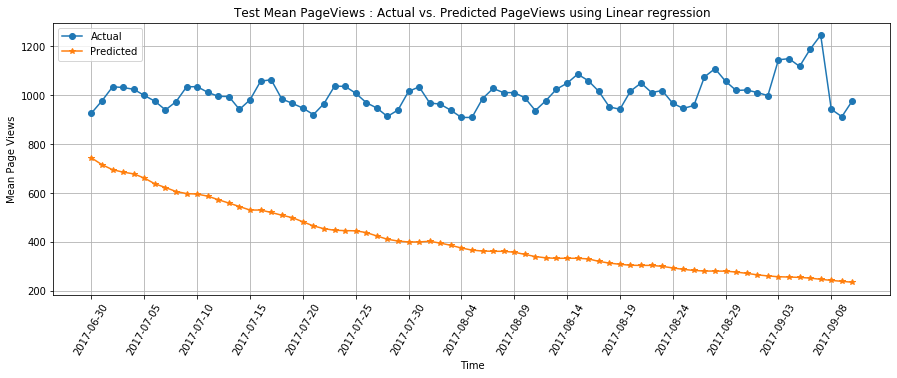

In [ ]:
#plot for mean of actual test and predicted test
plt.figure(figsize=(15, 5))
plt.title('Test Mean PageViews : Actual vs. Predicted PageViews using Linear regression')
actual_mean = test.iloc[:, :-4].mean(axis=0)
pred_mean   = test_data.mean(axis=0)

xtick_labels = [ x for x in enumerate(test_cols) if x[0]%5==0 ]
xtick_loc    = [ x[0] for x in xtick_labels ]
xtick_label  = [ x[1] for x in xtick_labels ]
b1 = plt.plot(actual_mean, marker="o")
b2 = plt.plot(pred_mean, marker="*")
plt.xlabel('Time')
plt.ylabel('Mean Page Views')
plt.grid()
plt.legend([b1[0], b2[0]], ['Actual', 'Predicted'])
plt.xticks(xtick_loc, xtick_label, rotation=60)
plt.show()

<p><li>From above Mean distribution of Actual vs. Predicted Page Views, we can see that for, for the initial period of the test data, model error was comparatively low. This starts increasing as we progress through the time.</li></p>
<p><li>Test data error of the model is significant but comparatively lower that Window Mean Model but model seems to over-fit in this case.</li></p>

#### [1.2.5] Test Data Analysis 

In [ ]:
best_window = 90

#testing with actual data
past_data_cols = complete_train.columns.tolist()[-best_window-4:]
past_data_cols.insert(0, 'Page')

past_data = complete_train[past_data_cols]
#past_data.head()

#getting date columns and non_date columns
date_cols = [ x for x in past_data.columns.tolist() if '-' in x ]
non_date  = [ x for x in past_data.columns.tolist() if x not in date_cols and x != 'Page' ]

#separating the ata into series of PageViews and Site features
pagename_X   = complete_train[non_date]
timeseries_X = complete_train[date_cols]

from sklearn.preprocessing import StandardScaler
#standardize the Site features
std_sclr      = StandardScaler()
X_pagename    = std_sclr.fit_transform(pagename_X)

In [ ]:
#loading the saved model
sq_reg = joblib.load('./ML_MODEL-linear_regression_squareloss.sav')

#running the prediction for test data
model_test = pd.DataFrame()
model_test['Page'] = complete_train.Page.values
for test_index in range(len(test_days)):
    X         = np.log1p(timeseries_X.iloc[:,-best_window:])
    X_lagged  = np.hstack((X_pagename_te, X))
    predicted = [ np.ceil(np.expm1(x)) for x in sq_reg.predict(X_lagged) ]
    model_test[test_days[test_index]]   = predicted
    timeseries_X[test_days[test_index]] = predicted

In [ ]:
f = open('Linear_Regression_SqLoss_Page_Count.csv', 'w')
f.write('Page|Visits'+'\n')
for col in model_test.iloc[:,-62:].columns.tolist():
  test_data = model_test[['Page',col]]
  pageviews = [ str(int(x)) for x in test_data.iloc[:,-1] ]
  pagename  = [ x+'_'+test_data.columns.tolist()[-1] for x in test_data.iloc[:,0] ]
  page_view = list(zip(pagename,pageviews))
  #writing it into file
  for line in page_view:
    n, c = line
    f.write(n+'|'+c)
    f.write('\n')
f.close()

test_data_final = pd.read_csv('./Linear_Regression_SqLoss_Page_Count.csv', sep='|')
#saving the final file
page_key.merge(test_data_final, how='left', on='Page')[['Id', 'Visits']].fillna(0).to_csv('./Test_Data_Linear_Regression_SqLoss.csv', index=False)

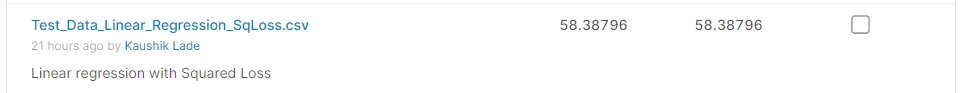

In [ ]:
models['Linear Regression(Sq. Loss)'].append('58.3880')

## [1.3] Linear Regression (Huber Loss)

<p>With certain Sites with higher Page Views being the outlier in the data, we will fit model using Huber Loss which is rhobust to Outliers</p>

#### [1.3.1] Hyper-parameter tuning : Best Lagged Window

In [ ]:
#taking log1p of both values, x_train and y_labels
Y = np.log1p(observed.values)

error = list()
for lag in lagged_window:
    print("**** Running with Lagged Window =",lag)
    X = np.log1p(timeseries_X.iloc[:,-lag:])
    X = np.hstack((X_pagename, X))
    smape_error = list()
    for alpha in alpha_range:  
        #print("Lag=",lag,"     Start Date : ",X.columns.tolist()[0],"     End Date :",X.columns.tolist()[-1])
        #fitting log_reg on lagged data
        log_reg = SGDRegressor(alpha=alpha, loss='huber', penalty='l2', \
                               fit_intercept=True, random_state=45)
        log_reg.fit(X, Y)
        #making prediction for last day of Train
        model_predicted = log_reg.predict(X)
        #calculating SMAPE and MAPE
        train_smape     = smoothed_smape(Y, model_predicted)
        #print("Lag=",lag,"     SMAPE=",train_smape)#,"     RMSE=",train_rmse, "     MAPE", train_mape)
        smape_error.append(train_smape)
    index = np.argmin(smape_error)
    best_alpha=alpha_range[index];min_smape=smape_error[index]
    error.append([best_alpha, min_smape])

index = np.argmin([ x[1] for x in error ])
best_window = lagged_window[index]
best_alpha, best_smape = error[index]
print("Best parameters : \nAlpha = {0}, \nLagged Window = {1}, \nMIN SMAPE = {2}"\
      .format(best_alpha, best_window, best_smape))

**** Running with Lagged Window = 7
**** Running with Lagged Window = 30
**** Running with Lagged Window = 90
**** Running with Lagged Window = 365
Best parameters : 
Alpha = 0.1, 
Lagged Window = 90, 
MIN SMAPE = 16.9958302787967


<p>
    With the Hyper-parameter Tuning of the model, we found :
    <li>Best Window of <b>90 days</b></li>
    <li>Best Alpha to be 0.1</li>
</p>

#### [1.3.2] Fitting model with Best Lagged window data

In [ ]:
#keeping an history values for future prediction
history = timeseries_X.iloc[:,-best_window:]

#preparing data for test run
#X = np.log1p(history.iloc[:, -best_window:])

#standardized the data
X = std_sclr.fit_transform(np.log1p(history.iloc[:, -best_window:]))

#staking it with page features
X = np.hstack((X_pagename, X))
log_reg = SGDRegressor(alpha=best_alpha, loss='huber', \
                     penalty='l2', fit_intercept=True, random_state=45)
log_reg.fit(X, Y)
#saving the best fit mode
joblib.dump(log_reg, './ML_MODEL-linear_regression_huberloss.sav')

#adding prediction of last train column as history column
history[train_last] = [ np.ceil(np.expm1(x)) for x in log_reg.predict(X) ]

#### [1.3.3] Running Model on CV Data

In [ ]:
test_data = pd.DataFrame()
test_cols = test.columns.tolist()[:-4]
#print(history.shape)
for test_index in range(len(test_cols)):
    #print(history.shape)
    #X         = np.log1p(history.iloc[:,-best_window:])
    
    #standardized thed ata
    X         = std_sclr.fit_transform(np.log1p(history.iloc[:,-best_window:]))
    
    X_lagged  = np.hstack((X_pagename_te, X))
    predicted = [ np.ceil(np.expm1(x)) for x in log_reg.predict(X_lagged) ]
    test_data[test_cols[test_index]] = predicted
    history[test_cols[test_index]]   = predicted
    #history[test_cols[test_index]]   = test.iloc[:, test_index]

test_smape = np.mean(smoothed_smape(test.iloc[:,:-4], test_data))
print("SMAPE on TEST DATA : ",test_smape)
test_rmse  = np.mean(rmse(test.iloc[: ,:-4], test_data))
print("RMSE  on TEST DATA : ",test_rmse)
models['Linear Regression (Huber LOSS)'] = [best_window, test_smape, test_rmse]

SMAPE on TEST DATA :  45.69585062490128
RMSE  on TEST DATA :  28966.58932053282


#### [1.3.4] SMAPE Performance : Actual vs. Forecasted values

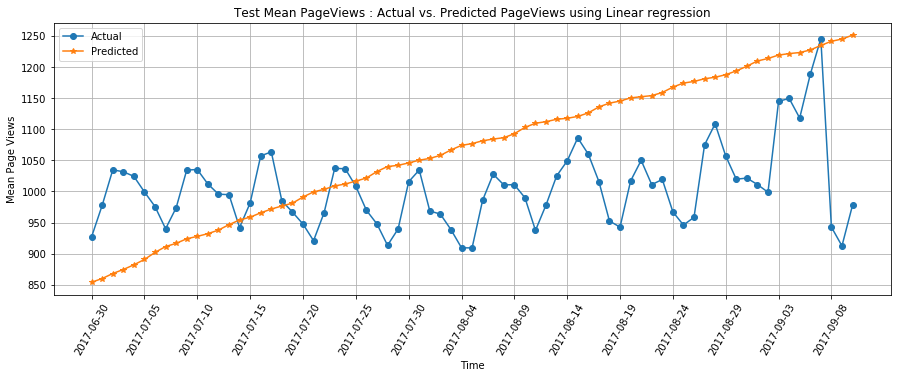

In [ ]:
#plot for mean of actual test and predicted test
plt.figure(figsize=(15, 5))
plt.title('Test Mean PageViews : Actual vs. Predicted PageViews using Linear regression')
actual_mean = test.iloc[:, :-4].mean(axis=0)
pred_mean   = test_data.mean(axis=0)

xtick_labels = [ x for x in enumerate(test_cols) if x[0]%5==0 ]
xtick_loc    = [ x[0] for x in xtick_labels ]
xtick_label  = [ x[1] for x in xtick_labels ]
b1 = plt.plot(actual_mean, marker="o")
b2 = plt.plot(pred_mean, marker="*")
plt.xlabel('Time')
plt.ylabel('Mean Page Views')
plt.grid()
plt.legend([b1[0], b2[0]], ['Actual', 'Predicted'])
plt.xticks(xtick_loc, xtick_label, rotation=60)
plt.show()

<p><li>With the cyclic Mean views of actual test data, we can see that the model fits the data linearly to forecast the Page Views on the test data.</li></p>
<p><li>SMAPE on Test data with Linear Regression with Huber Loss is significantly low as model fits the data linearly. Model also overfits as we progress through the data.</li></p>

#### [1.3.5] Testing ofn actual Test data

In [ ]:
best_window = 90

#testing with actual data
past_data_cols = complete_train.columns.tolist()[-best_window-4:]
past_data_cols.insert(0, 'Page')

past_data = complete_train[past_data_cols]
#past_data.head()

#getting date columns and non_date columns
date_cols = [ x for x in past_data.columns.tolist() if '-' in x ]
non_date  = [ x for x in past_data.columns.tolist() if x not in date_cols and x != 'Page' ]

#separating the ata into series of PageViews and Site features
pagename_X   = complete_train[non_date]
timeseries_X = complete_train[date_cols]

from sklearn.preprocessing import StandardScaler
#standardize the Site features
std_sclr      = StandardScaler()
X_pagename    = std_sclr.fit_transform(pagename_X)

In [ ]:
#loading the saved model
log_reg_hu = joblib.load('./ML_MODEL-linear_regression_huberloss.sav')

#running the prediction for test data
model_test = pd.DataFrame()
model_test['Page'] = complete_train.Page.values
for test_index in range(len(test_days)):
    X         = np.log1p(timeseries_X.iloc[:,-best_window:])
    X_lagged  = np.hstack((X_pagename_te, X))
    predicted = [ np.ceil(np.expm1(x)) for x in log_reg_hu.predict(X_lagged) ]
    model_test[test_days[test_index]]   = predicted
    timeseries_X[test_days[test_index]] = predicted

In [ ]:
f = open('Linear_Regression_HuberLoss_Page_Count.csv', 'w')
f.write('Page|Visits'+'\n')
for col in model_test.iloc[:,-62:].columns.tolist():
  test_data = model_test[['Page',col]]
  pageviews = [ str(int(x)) for x in test_data.iloc[:,-1] ]
  pagename  = [ x+'_'+test_data.columns.tolist()[-1] for x in test_data.iloc[:,0] ]
  page_view = list(zip(pagename,pageviews))
  #writing it into file
  for line in page_view:
    n, c = line
    f.write(n+'|'+c)
    f.write('\n')
f.close()

test_data_final = pd.read_csv('./Linear_Regression_HuberLoss_Page_Count.csv', sep='|')

#saving the final file
page_key.merge(test_data_final, how='left', on='Page')[['Id', 'Visits']].fillna(0).to_csv('./Test_Data_Linear_Regression_HuberLoss.csv', index=False)

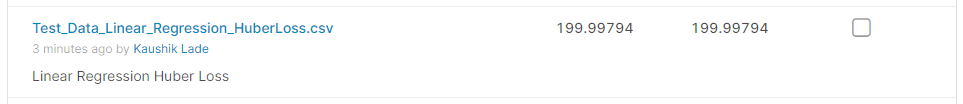

In [ ]:
models['Linear Regression (Huber LOSS)'].append('199.99794')

## [1.4] Decision Tree Regressor

<p>Analysis using decision trees for forecasting</p>

#### [1.4.1] Hyper-parameter Tuning : Best Lag Window

In [ ]:
Y = np.log1p(observed.values)
depth_list         = [ 3, 5, 7, 9, 11 ]
samples_split_list = [ 2, 3, 5 ]

param_dict = {'max_depth':depth_list, 'min_samples_split':samples_split_list}

In [ ]:
error = list()
for lag in lagged_window:
    print("**** Running model for Lag Window %d"%lag)
    X = np.log1p(timeseries_X.iloc[:, -lag:])
    X = np.hstack((X_pagename, X))
    dt_regressor = DecisionTreeRegressor(max_features='sqrt', random_state=45)
    model        = RandomizedSearchCV(dt_regressor, param_dict, random_state=27, n_jobs=-1)
    model.fit(X, Y)
    best_param_dict = model.best_params_
    #print(best_param_dict)
    best_depth   = best_param_dict['max_depth']
    best_split   = best_param_dict['min_samples_split']
    dt_regressor = DecisionTreeRegressor(max_depth         = best_depth, \
                                         min_samples_split = best_split, \
                                         random_state=45)
    dt_regressor.fit(X, Y)
    model_predicted = dt_regressor.predict(X)
    #calculating SMAPE and MAPE
    train_smape     = smape(observed, np.ceil(np.expm1(model_predicted)))
    #train_mape      = mape(Y, model_predicted)
    error.append([train_smape, best_param_dict])
index = np.argmin([x[0] for x in error])
best_window = lagged_window[index]
best_params = error[index][1]
best_smape = error[index][0]

print("Best parameters found for : \nLagged Window = {0}, \n\nMIN SMAPE ={1}"\
      .format(best_window, best_smape))

**** Running model for Lag Window 7
**** Running model for Lag Window 30
**** Running model for Lag Window 90
**** Running model for Lag Window 365
Best parameters found for : 
Lagged Window = 365, 

MIN SMAPE =32.870312566736786


#### [1.4.2] Fitting model with Best Lagged window

In [ ]:
#keeping an history values for future prediction
history = timeseries_X.iloc[:,-best_window:]

#preparing data for test run
X = np.log1p(history.iloc[:, -best_window:])
#staking it with page features
X = np.hstack((X_pagename, X))

#fitting a RF Regressor model with best parameters
best_depth   = best_params['max_depth']
best_split   = best_params['min_samples_split']
dt_regressor = DecisionTreeRegressor(max_depth         = best_depth, \
                                     min_samples_split = best_split, \
                                     random_state=45)
dt_regressor.fit(X, Y)

#saving the model
joblib.dump(dt_regressor, './ML_MODEL-decisiontree_regressor.sav')

#adding prediction of last train column as history column
history[train_last] = [ np.ceil(np.expm1(x)) for x in dt_regressor.predict(X) ]

#### [1.4.3] Testing the model on CV data

In [ ]:
test_data = pd.DataFrame()
test_cols = test.columns.tolist()[:-4]
#print(history.shape)
for test_index in range(len(test_cols)):
    #print(history.shape)
    X         = np.log1p(history.iloc[:,-best_window:])
    X_lagged  = np.hstack((X_pagename_te, X))
    predicted = [ np.ceil(np.expm1(x)) for x in dt_regressor.predict(X_lagged) ]
    test_data[test_cols[test_index]] = predicted
    history[test_cols[test_index]]   = predicted

test_smape = np.mean(smoothed_smape(test.iloc[:,:-4], test_data))
print("SMAPE on TEST DATA : ",test_smape)
test_rmse  = np.mean(rmse(test.iloc[: ,:-4], test_data))
print("RMSE  on TEST DATA : ",test_rmse)
models['Decision Tree Regression'] = [best_window, test_smape, test_rmse]

SMAPE on TEST DATA :  46.87272271390723
RMSE  on TEST DATA :  13554.727948613523


#### [1.4.4] SMAPE Performance : Actual vs. Forecasted values

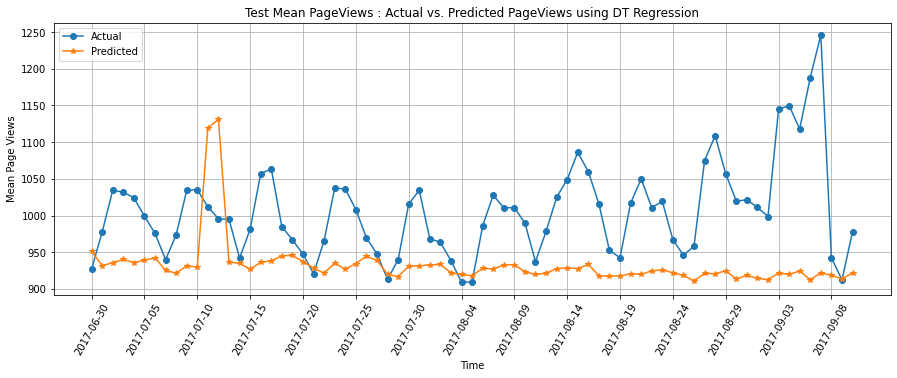

In [ ]:
#plot for mean of actual test and predicted test
plt.figure(figsize=(15, 5))
plt.title('Test Mean PageViews : Actual vs. Predicted PageViews using DT Regression')
actual_mean = test.iloc[:, :-4].mean(axis=0)
pred_mean   = test_data.mean(axis=0)

xtick_labels = [ x for x in enumerate(test_cols) if x[0]%5==0 ]
xtick_loc    = [ x[0] for x in xtick_labels ]
xtick_label  = [ x[1] for x in xtick_labels ]

b1 = plt.plot(actual_mean, marker="o")
b2 = plt.plot(pred_mean, marker="*")
plt.xlabel('Time')
plt.ylabel('Mean Page Views')
plt.grid()
plt.legend([b1[0], b2[0]], ['Actual', 'Predicted'])
plt.xticks(xtick_loc, xtick_label, rotation=60)
plt.show()  

#### [1.4.5] Testing model on Actual test data

In [ ]:
#testing with actual data
past_data_cols = complete_train.columns.tolist()[-best_window-4:]
past_data_cols.insert(0, 'Page')

past_data = complete_train[past_data_cols]
#past_data.head()

#getting date columns and non_date columns
date_cols = [ x for x in past_data.columns.tolist() if '-' in x ]
non_date  = [ x for x in past_data.columns.tolist() if x not in date_cols and x != 'Page' ]

#separating the ata into series of PageViews and Site features
pagename_X   = complete_train[non_date]
timeseries_X = complete_train[date_cols]

from sklearn.preprocessing import StandardScaler
#standardize the Site features
std_sclr      = StandardScaler()
X_pagename    = std_sclr.fit_transform(pagename_X)

In [ ]:
#loading the saved model
dt_reg = joblib.load('./ML_MODEL-decisiontree_regressor.sav')

#running the prediction for test data
model_test = pd.DataFrame()
model_test['Page'] = complete_train.Page.values
for test_index in range(len(test_days)):
    X         = np.log1p(timeseries_X.iloc[:,-best_window:])
    X_lagged  = np.hstack((X_pagename_te, X))
    predicted = [ np.ceil(np.expm1(x)) for x in dt_reg.predict(X_lagged) ]
    model_test[test_days[test_index]]   = predicted
    timeseries_X[test_days[test_index]] = predicted

In [ ]:
f = open('Decision_Tree_Page_Count.csv', 'w')
f.write('Page|Visits'+'\n')
for col in model_test.iloc[:,-62:].columns.tolist():
  test_data = model_test[['Page',col]]
  pageviews = [ str(int(x)) for x in test_data.iloc[:,-1] ]
  pagename  = [ x+'_'+test_data.columns.tolist()[-1] for x in test_data.iloc[:,0] ]
  page_view = list(zip(pagename,pageviews))
  #writing it into file
  for line in page_view:
    n, c = line
    f.write(n+'|'+c)
    f.write('\n')
  [ f.write(n+','+c+'\n') for (n, c) in page_view ]
f.close()

test_data_final = pd.read_csv('./Decision_Tree_Page_Count.csv', sep='|')

#saving the final file
page_key.merge(test_data_final, how='left', on='Page')[['Id', 'Visits']].fillna(0).to_csv('./Test_Data_Decision_Tree.csv', index=False)

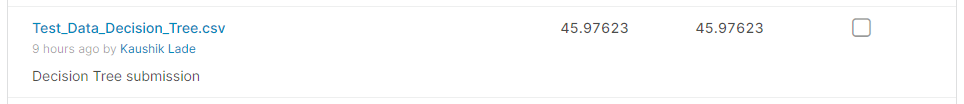

In [ ]:
models['Decision Tree Regression'].append('45.97623')

## [1.5] AdaBoost Regressor

In [ ]:
Y = np.log1p(observed.values)
estimator_list = [ 50, 100, 200, 500 ]
lr_list        = [  1e-2, 1e-1, 1, 10, 100 ]

param_dict = {'n_estimators':estimator_list, 'learning_rate':lr_list}

best_decision_tree = joblib.load('./ML_MODEL-decisiontree_regressor.sav')
best_decision_tree.get_params

<bound method BaseEstimator.get_params of DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=45, splitter='best')>

#### [1.5.1] Hyper-Parameter Tuning : Lagged Window

In [ ]:
error = list()
for lag in lagged_window:
    print("**** Running model for Lag Window %d"%lag)
    X = np.log1p(timeseries_X.iloc[:, -lag:])
    X = np.hstack((X_pagename, X))
    adaboost = AdaBoostRegressor(base_estimator=best_decision_tree, loss='square', \
                                 random_state=45)
    #dt_regressor = DecisionTreeRegressor(max_features='sqrt', random_state=45)
    model        = RandomizedSearchCV(adaboost, param_dict, \
                                      random_state=45, n_jobs=-1)
    model.fit(X, Y)
    best_param_dict = model.best_params_
    #print(best_param_dict)
    best_estimator = best_param_dict['n_estimators']
    best_lr        = best_param_dict['learning_rate']
    adaboost       = AdaBoostRegressor(base_estimator=best_decision_tree, \
                                       n_estimators=best_estimator, \
                                       learning_rate=best_lr, \
                                       loss='square', random_state=45)
    adaboost.fit(X, Y)
    model_predicted = adaboost.predict(X)
    #calculating SMAPE and MAPE
    train_smape     = smape(observed, np.ceil(np.expm1(model_predicted)))
    #train_mape      = mape(Y, model_predicted)
    error.append([train_smape, best_param_dict])
index = np.argmin([x[0] for x in error])
best_window = lagged_window[index]
best_params = error[index][1]
best_smape = error[index][0]

print("Best parameters found for : \nLagged Window = {0}, \n\nMIN SMAPE ={1}"\
      .format(best_window, best_smape))

**** Running model for Lag Window 7
**** Running model for Lag Window 30
**** Running model for Lag Window 90
**** Running model for Lag Window 365
Best parameters found for : 
Lagged Window = 365, 

MIN SMAPE =31.71503990480388


#### [1.5.2] Model Re-Fitting : with Best lagged window

In [ ]:
#keeping an history values for future prediction
history = timeseries_X.iloc[:,-best_window:]

#preparing data for test run
X = np.log1p(history.iloc[:, -best_window:])
#staking it with page features
X = np.hstack((X_pagename, X))

#fitting a RF Regressor model with best parameters
best_estimators = best_params['n_estimators']
best_lr         = best_params['learning_rate']

adaboost       = AdaBoostRegressor(base_estimator = best_decision_tree, \
                                    n_estimators  = best_estimators, \
                                    learning_rate = best_lr, \
                                    loss='square', random_state=45) 
adaboost.fit(X, Y)

#saving the model
joblib.dump(adaboost, './ML_MODEL-adaboost_regressor.sav')

#adding prediction of last train column as history column
history[train_last] = [ np.ceil(np.expm1(x)) for x in adaboost.predict(X) ]

#### [1.5.3] CV Data Analysis

In [ ]:
test_data = pd.DataFrame()
test_cols = test.columns.tolist()[:-4]
#print(history.shape)
for test_index in range(len(test_cols)):
    #print(history.shape)
    X         = np.log1p(history.iloc[:,-best_window:])
    X_lagged  = np.hstack((X_pagename_te, X))
    predicted = [ np.ceil(np.expm1(x)) for x in adaboost.predict(X_lagged) ]
    test_data[test_cols[test_index]] = predicted
    history[test_cols[test_index]]   = predicted

test_smape = np.mean(smoothed_smape(test.iloc[:,:-4], test_data))
print("SMAPE on TEST DATA : ",test_smape)
test_rmse  = np.mean(rmse(test.iloc[: ,:-4], test_data))
print("RMSE  on TEST DATA : ",test_rmse)
models['AdaBoost Regression'] = [best_window, test_smape, test_rmse]

SMAPE on TEST DATA :  47.007245748502946
RMSE  on TEST DATA :  11182.370992502747


#### [1.5.4] Model Performance : SMAPE on Actual vs. Forecasted values

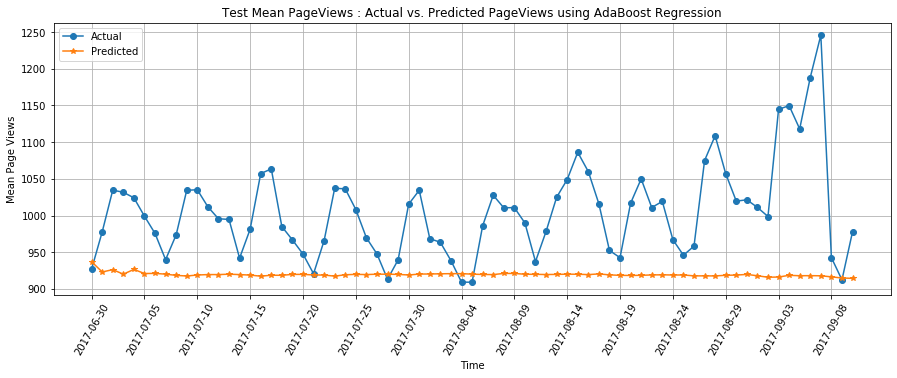

In [ ]:
#plot for mean of actual test and predicted test
plt.figure(figsize=(15, 5))
plt.title('Test Mean PageViews : Actual vs. Predicted PageViews using AdaBoost Regression')
actual_mean = test.iloc[:, :-4].mean(axis=0)
pred_mean   = test_data.mean(axis=0)

xtick_labels = [ x for x in enumerate(test_cols) if x[0]%5==0 ]
xtick_loc    = [ x[0] for x in xtick_labels ]
xtick_label  = [ x[1] for x in xtick_labels ]

b1 = plt.plot(actual_mean, marker="o")
b2 = plt.plot(pred_mean, marker="*")
plt.xlabel('Time')
plt.ylabel('Mean Page Views')
plt.grid()
plt.legend([b1[0], b2[0]], ['Actual', 'Predicted'])
plt.xticks(xtick_loc, xtick_label, rotation=60)
plt.show()

#### [1.5.5] Test Data Analysis 

In [12]:
best_window = 365
#testing with actual data
past_data_cols = complete_train.columns.tolist()[-best_window-4:]
past_data_cols.insert(0, 'Page')

past_data = complete_train[past_data_cols]
#past_data.head()

#getting date columns and non_date columns
date_cols = [ x for x in past_data.columns.tolist() if '-' in x ]
non_date  = [ x for x in past_data.columns.tolist() if x not in date_cols and x != 'Page' ]

#separating the ata into series of PageViews and Site features
pagename_X   = complete_train[non_date]
timeseries_X = complete_train[date_cols]

from sklearn.preprocessing import StandardScaler
#standardize the Site features
std_sclr      = StandardScaler()
X_pagename    = std_sclr.fit_transform(pagename_X)

In [13]:
#loading the saved model
adaboost = joblib.load('./ML_MODEL-adaboost_regressor.sav')

#running the prediction for test data
model_test = pd.DataFrame()
model_test['Page'] = complete_train.Page.values
for test_index in range(len(test_days)):
    X         = np.log1p(timeseries_X.iloc[:,-best_window:])
    X_lagged  = np.hstack((X_pagename_te, X))
    predicted = [ np.ceil(np.expm1(x)) for x in adaboost.predict(X_lagged) ]
    model_test[test_days[test_index]]   = predicted
    timeseries_X[test_days[test_index]] = predicted

In [15]:
f = open('AdaBoost_Page_Count.csv', 'w')
f.write('Page|Visits'+'\n')
for col in model_test.iloc[:,-62:].columns.tolist():
  test_data = model_test[['Page',col]]
  pageviews = [ str(int(x)) for x in test_data.iloc[:,-1] ]
  pagename  = [ x+'_'+test_data.columns.tolist()[-1] for x in test_data.iloc[:,0] ]
  page_view = list(zip(pagename,pageviews))
  #writing it into file
  for line in page_view:
    n, c = line
    f.write(n+'|'+c)
    f.write('\n')
f.close()

test_data_final = pd.read_csv('./AdaBoost_Page_Count.csv', sep='|')

#saving the final file
page_key.merge(test_data_final, how='left', on='Page')[['Id', 'Visits']].fillna(0).to_csv('./Test_Data_AdaBoostRegression.csv', index=False)
del test_data_final

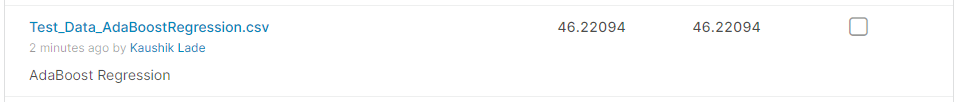

In [ ]:
models['AdaBoost Regression'].append('46.22094')

## [1.6] Random Forest Regressor

In [ ]:
#class label for Y
Y = np.log1p(observed.values)

slw_xgboost = [ 7, 30, 90, 365 ]

estimator_list     = [ 100, 300, 500 ]
depth_list         = [ 3, 5, 7, 9, 11 ]
samples_split_list = [ 2, 3, 5 ]

param_dict = { 'n_estimators':estimator_list, 'max_depth':depth_list, \
              'min_samples_split':samples_split_list }

#### [1.6.1] Hyper-Parameter Tuning : Lagged Window

In [ ]:
warnings.filterwarnings('ignore')
error = list()
for lag in lagged_window:
    print("**** Running model for Lag Window %d"%lag)
    X = np.log1p(timeseries_X.iloc[:, -lag:])
    X = np.hstack((X_pagename, X))
    randomforest = RandomForestRegressor(n_jobs=-1, random_state=45)
    model = RandomizedSearchCV(randomforest, param_dict, \
                               random_state=45, n_jobs=-1)
    model.fit(X, Y)
    best_param_dict = model.best_params_
    #print(best_param_dict)
    #fitting model again on best parameters for that window
    best_estimator = best_param_dict['n_estimators']
    best_depth     = best_param_dict['max_depth']
    best_split     = best_param_dict['min_samples_split']
    randomforest   = RandomForestRegressor(n_estimators = best_estimator, \
                                           max_depth = best_depth, \
                                           min_samples_split = best_split, \
                                           n_jobs=-1, random_state=45)
    randomforest.fit(X, Y)
    model_predicted = randomforest.predict(X)
    #calculating SMAPE and MAPE
    train_smape = smoothed_smape(observed, np.ceil(np.expm1(model_predicted)))
    #train_mape  = mape(Y, model_predicted)
    error.append([train_smape, best_param_dict])

#getting the best values
index       = np.argmin([x[0] for x in error])
best_window = lagged_window[index]
best_params = error[index][1]
best_smape  = error[index][0]

print("\n\nBest parameters found for : \nLagged Window = {0}, \n\nMIN SMAPE ={1}"\
      .format(best_window, best_smape))


**** Running model for Lag Window 7
**** Running model for Lag Window 30
**** Running model for Lag Window 90
**** Running model for Lag Window 365
Best parameters found for : 
Lagged Window = 90, 

MIN SMAPE =31.377692884198005



#### [1.6.2] Model Re-Fitting : with Best lagged window

In [ ]:
best_window = 90
best_params = {'n_estimators':300, 'min_samples_split':2, 'max_depth' : 9}
Y = np.log1p(observed.values)
#keeping an history values for future prediction
history = timeseries_X.iloc[:,-best_window:]

#preparing data for test run
X = np.log1p(history.iloc[:, -best_window:])
#staking it with page features
X = np.hstack((X_pagename, X))

best_estimator = best_params['n_estimators']
best_depth     = best_params['max_depth']
best_split     = best_params['min_samples_split']

randomforest = RandomForestRegressor(n_estimators = best_estimator, \
                                     max_depth = best_depth, \
                                     min_samples_split = best_split, \
                                     n_jobs=-1, random_state=45)
randomforest.fit(X, Y)
#saving the best fit mode
import joblib
joblib.dump(randomforest, './ML_MODEL-randomforest_regression.sav')

#adding prediction of last train column as history column
history[train_last] = [ np.ceil(np.expm1(x)) for x in randomforest.predict(X) ]

#### [1.6.3] CV Data Analysis

In [ ]:
randomforest = joblib.load('./ML_MODEL-randomforest_regression.sav')
test_data = pd.DataFrame()
test_cols = test.columns.tolist()[:-4]
#print(history.shape)
for test_index in range(len(test_cols)):
    #print(history.shape)
    X         = np.log1p(history.iloc[:,-best_window:])
    X_lagged  = np.hstack((X_pagename_te, X))
    predicted = [ np.ceil(np.expm1(x)) for x in randomforest.predict(X_lagged) ]
    test_data[test_cols[test_index]] = predicted
    history[test_cols[test_index]]   = predicted

test_smape = np.mean(smoothed_smape(test.iloc[:,:-4], test_data))
print("SMAPE on TEST DATA : ",test_smape)
test_rmse  = np.mean(rmse(test.iloc[: ,:-4], test_data))
print("RMSE  on TEST DATA : ",test_rmse)
models['RandomForest Regression'] = [best_window, test_smape, test_rmse]

SMAPE on TEST DATA :  45.833274877164875
RMSE  on TEST DATA :  18395.072940934155


#### [1.6.4] Model Performance : SMAPE on Actual vs. Forecasted values

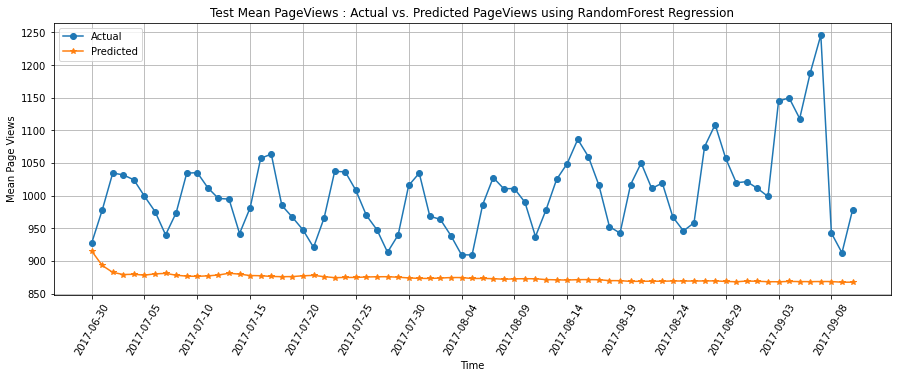

In [ ]:
#plot for mean of actual test and predicted test
plt.figure(figsize=(15, 5))
plt.title('Test Mean PageViews : Actual vs. Predicted PageViews using RandomForest Regression')
actual_mean = test.iloc[:, :-4].mean(axis=0)
pred_mean   = test_data.mean(axis=0)

xtick_labels = [ x for x in enumerate(test_cols) if x[0]%5==0 ]
xtick_loc    = [ x[0] for x in xtick_labels ]
xtick_label  = [ x[1] for x in xtick_labels ]

b1 = plt.plot(actual_mean, marker="o")
b2 = plt.plot(pred_mean, marker="*")
plt.xlabel('Time')
plt.ylabel('Mean Page Views')
plt.grid()
plt.legend([b1[0], b2[0]], ['Actual', 'Predicted'])
plt.xticks(xtick_loc, xtick_label, rotation=60)
plt.show()  

#### [1.6.5] Test Data Analysis 

In [ ]:
best_window = 90
#testing with actual data
past_data_cols = complete_train.columns.tolist()[-best_window-4:]
past_data_cols.insert(0, 'Page')

past_data = complete_train[past_data_cols]
#past_data.head()

#getting date columns and non_date columns
date_cols = [ x for x in past_data.columns.tolist() if '-' in x ]
non_date  = [ x for x in past_data.columns.tolist() if x not in date_cols and x != 'Page' ]

#separating the ata into series of PageViews and Site features
pagename_X   = complete_train[non_date]
timeseries_X = complete_train[date_cols]

from sklearn.preprocessing import StandardScaler
#standardize the Site features
std_sclr      = StandardScaler()
X_pagename    = std_sclr.fit_transform(pagename_X)

In [ ]:
#loading the saved model
randomforest = joblib.load('./ML_MODEL-randomforest_regression.sav')

#running the prediction for test data
model_test = pd.DataFrame()
model_test['Page'] = complete_train.Page.values
for test_index in range(len(test_days)):
    X         = np.log1p(timeseries_X.iloc[:,-best_window:])
    X_lagged  = np.hstack((X_pagename_te, X))
    predicted = [ np.ceil(np.expm1(x)) for x in randomforest.predict(X_lagged) ]
    model_test[test_days[test_index]]   = predicted
    timeseries_X[test_days[test_index]] = predicted

In [ ]:
f = open('RandomForest_Page_Count.csv', 'w')
f.write('Page|Visits'+'\n')
for col in model_test.iloc[:,-62:].columns.tolist():
  test_data = model_test[['Page',col]]
  pageviews = [ str(int(x)) for x in test_data.iloc[:,-1] ]
  pagename  = [ x+'_'+test_data.columns.tolist()[-1] for x in test_data.iloc[:,0] ]
  page_view = list(zip(pagename,pageviews))
  #writing it into file
  for line in page_view:
    n, c = line
    f.write(n+'|'+c)
    f.write('\n')
f.close()

test_data_final = pd.read_csv('./RandomForest_Page_Count.csv', sep='|')

#saving the final file
page_key.merge(test_data_final, how='left', on='Page')[['Id', 'Visits']].fillna(0).to_csv('./Test_Data_RFRegression.csv', index=False)

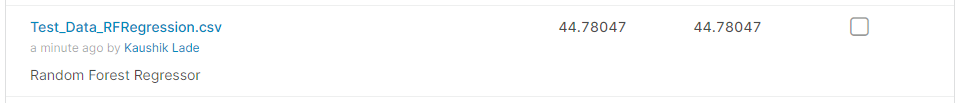

In [ ]:
models['RandomForest Regression'].append('44.78047')

## [1.7] XGBoost Regressor

<p><li>Tree based Ensample can be used to predict the model</li></p>

#### [1.7.1] Hyper-Parameter Tuning : Lagged Window

In [ ]:
#class label for Y
Y = np.log1p(observed.values)

slw_xgboost = [ 7, 30, 90, 365 ]

estimator_list  = [ 100, 300, 500, 1000 ]
max_depth_list  = [ 3, 5, 7 ]
lr_list         = [ 0.001, 0.01, 0.1 ]
cs_list         = [ 0.4, 0.6, 0.8 ]

xgb_param_dict = {'n_estimators':estimator_list, 'max_depth':max_depth_list, \
                  'learning_rate':lr_list, 'colsample_bytree':cs_list}

In [ ]:
warnings.filterwarnings('ignore')
error = list()
for lag in slw_xgboost:
    print("**** Running model for Lag Window %d"%lag)
    X = np.log1p(timeseries_X.iloc[:, -lag:])
    X = np.hstack((X_pagename, X))
    xgboost = xgb.XGBRegressor(objective='reg:squarederror', \
                               n_jobs=-1, random_state=45)
    model   = RandomizedSearchCV(xgboost, xgb_param_dict, \
                                 random_state=45, verbose=0, n_jobs=-1)
    model.fit(X, Y)
    best_param_dict = model.best_params_
    #print(best_param_dict)
    
    #fitting model again on best parameters for that window
    best_estimator = best_param_dict['n_estimators']
    best_depth     = best_param_dict['max_depth']
    best_lr        = best_param_dict['learning_rate']
    best_cs        = best_param_dict['colsample_bytree']
    xgboost        = xgb.XGBRegressor(objective        = 'reg:squarederror', \
                                      n_estimators     = best_estimator, \
                                      max_depth        = best_depth, \
                                      learning_rate    = best_lr, \
                                      colsample_bytree = best_cs, \
                                      n_jobs=-1, random_state=45)
    xgboost.fit(X, Y)
    model_predicted = xgboost.predict(X)
    
    #calculating SMAPE and MAPE
    train_smape = smoothed_smape(observed, np.ceil(np.expm1(model_predicted)))
    train_mape  = mape(Y, model_predicted)
    error.append([train_smape, best_param_dict])

#getting the best values
index       = np.argmin([x[0] for x in error])
best_window = slw_xgboost[index]
best_params = error[index][1]
best_smape  = error[index][0]

print("\n\nBest parameters found for : \nLagged Window = {0}, \n\nMIN SMAPE ={1}"\
      .format(best_window, best_smape))

**** Running model for Lag Window 7
**** Running model for Lag Window 30
**** Running model for Lag Window 90
**** Running model for Lag Window 365


Best parameters found for : 
Lagged Window = 365, 

MIN SMAPE =27.19330372386823


<p>
    With the Hyper-parameter Tuning of the model, we found :
    <li>Best Window of <b>365 days</b></li>
</p>

#### [1.7.2] Model Re-Fitting : with Best lagged window

In [ ]:
#keeping an history values for future prediction
history = timeseries_X.iloc[:,-best_window:]

#preparing data for test run
X = np.log1p(history.iloc[:, -best_window:])
#staking it with page features
X = np.hstack((X_pagename, X))

xgboost        = xgb.XGBRegressor(objective        = 'reg:squarederror', \
                                  n_estimators     = best_params['n_estimators'], \
                                  max_depth        = best_params['max_depth'], \
                                  learning_rate    = best_params['learning_rate'], \
                                  colsample_bytree = best_params['colsample_bytree'], \
                                  n_jobs=-1, random_state=45)
xgboost.fit(X, Y)
#saving the best fit mode
joblib.dump(xgboost, './ML_MODEL-xgboost_regressor.sav')

#adding prediction of last train column as history column
history[train_last] = [ np.ceil(np.expm1(x)) for x in xgboost.predict(X) ]

#### [1.7.3] CV Data Analysis

In [ ]:
test_data = pd.DataFrame()
test_cols = test.columns.tolist()[:-4]
#print(history.shape)
for test_index in range(len(test_cols)):
    #print(history.shape)
    X         = np.log1p(history.iloc[:,-best_window:])
    X_lagged  = np.hstack((X_pagename_te, X))
    predicted = [ np.ceil(np.expm1(x)) for x in xgboost.predict(X_lagged) ]
    test_data[test_cols[test_index]] = predicted
    history[test_cols[test_index]]   = predicted

test_smape = np.mean(smoothed_smape(test.iloc[:,:-4], test_data))
print("SMAPE on TEST DATA : ",test_smape)
test_rmse  = np.mean(rmse(test.iloc[: ,:-4], test_data))
print("RMSE  on TEST DATA : ",test_rmse)
models['XGBoost Regression'] = [best_window, test_smape, test_rmse]

SMAPE on TEST DATA :  46.629618056475344
RMSE  on TEST DATA :  1057967.7649643465


#### [1.7.4] Model Performance : SMAPE on Actual vs. Forecasted values

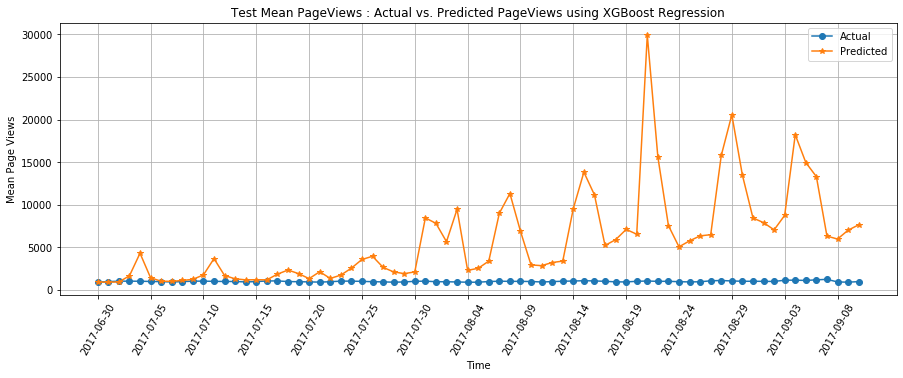

In [ ]:
#plot for mean of actual test and predicted test
plt.figure(figsize=(15, 5))
plt.title('Test Mean PageViews : Actual vs. Predicted PageViews using XGBoost Regression')
actual_mean = test.iloc[:, :-4].mean(axis=0)
pred_mean   = test_data.mean(axis=0)

xtick_labels = [ x for x in enumerate(test_cols) if x[0]%5==0 ]
xtick_loc    = [ x[0] for x in xtick_labels ]
xtick_label  = [ x[1] for x in xtick_labels ]

b1 = plt.plot(actual_mean, marker="o")
b2 = plt.plot(pred_mean, marker="*")
plt.xlabel('Time')
plt.ylabel('Mean Page Views')
plt.grid()
plt.legend([b1[0], b2[0]], ['Actual', 'Predicted'])
plt.xticks(xtick_loc, xtick_label, rotation=60)
plt.show()  

<p><li>Comparing Mean Page Views of Actual vs. Forecasted Mean shows, XGBoost model tend to Forecast too high when there is sharp rise in actual values. It fits non-linearly to the given data.</li></p>
<p><li>We can see, model overfits to the given test data and hence the SMAPE is high compared to thet of Linear Regression</li></p>

#### [1.7.5] Test Data Analysis 

In [ ]:
#testing with actual data
past_data_cols = complete_train.columns.tolist()[-best_window-4:]
past_data_cols.insert(0, 'Page')

past_data = complete_train[past_data_cols]
#past_data.head()

#getting date columns and non_date columns
date_cols = [ x for x in past_data.columns.tolist() if '-' in x ]
non_date  = [ x for x in past_data.columns.tolist() if x not in date_cols and x != 'Page' ]

#separating the ata into series of PageViews and Site features
pagename_X   = complete_train[non_date]
timeseries_X = complete_train[date_cols]

from sklearn.preprocessing import StandardScaler
#standardize the Site features
std_sclr      = StandardScaler()
X_pagename    = std_sclr.fit_transform(pagename_X)

In [ ]:
#loading the saved model
xgb = joblib.load('./ML_MODEL-xgboost_regressor.sav')

#running the prediction for test data
model_test = pd.DataFrame()
model_test['Page'] = complete_train.Page.values
for test_index in range(len(test_days)):
    X         = np.log1p(timeseries_X.iloc[:,-best_window:])
    X_lagged  = np.hstack((X_pagename_te, X))
    predicted = [ np.ceil(np.expm1(x)) for x in xgb.predict(X_lagged) ]
    model_test[test_days[test_index]]   = predicted
    timeseries_X[test_days[test_index]] = predicted

In [ ]:
f = open('XGBRegression_Page_Count.csv', 'w')
f.write('Page|Visits'+'\n')
for col in model_test.iloc[:,-62:].columns.tolist():
  test_data = model_test[['Page',col]]
  pageviews = [ str(int(x)) for x in test_data.iloc[:,-1] ]
  pagename  = [ x+'_'+test_data.columns.tolist()[-1] for x in test_data.iloc[:,0] ]
  page_view = list(zip(pagename,pageviews))
  #writing it into file
  for line in page_view:
    n, c = line
    f.write(n+'|'+c)
    f.write('\n')
f.close()

test_data_final = pd.read_csv('./XGBRegression_Page_Count.csv', sep='|')

#saving the final file
page_key.merge(test_data_final, how='left', on='Page')[['Id', 'Visits']].fillna(0).to_csv('./Test_Data_XGBRegression.csv', index=False)

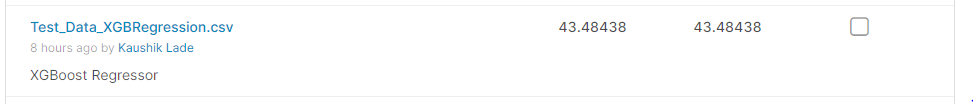

In [ ]:
models['XGBoost Regression'].append('43.48438')

# [2] Conclusion

In [18]:
from prettytable import PrettyTable
    
ml_models = PrettyTable()

ml_models.field_names = ["Model", "Best Window", "Test SMAPE", "Test RMSE", "Kaggle Score"]

for k, v in models.items():
    ml_models.add_row([k,v[0], round(v[1], 5), round(v[2], 5), round(v[3], 5)])

print(ml_models)

+--------------------------------+-------------+------------+---------------+--------------+
|             Model              | Best Window | Test SMAPE |   Test RMSE   | Kaggle Score |
+--------------------------------+-------------+------------+---------------+--------------+
|          Window Mean           |      7      |  78.2602   |   56034.8452  |   44.9267    |
|  Linear Regression(Sq. Loss)   |      90     |  60.02821  |  42788.35482  |   58.3880    |
|    Decision Tree Regression    |     365     |  46.8727   |   13554.7280  |   45.97623   |
|      AdaBoost Regression       |     365     |  47.0073   |   11182.3710  |   46.2209    |
|    RandomForest Regression     |      90     |  45.8333   |   18395.0729  |   44.78047   |
| Linear Regression (Huber LOSS) |      90     |  45.69585  |  28966.58932  |  199.99794   |
|       XGBoost Regression       |     365     |  46.62962  | 1057967.76496 |   43.48438   |
+--------------------------------+-------------+------------+---------

<p>
    Our main approach in this modeling is to use previous data to forecast the pageviews of test data. Here, 6 ML models
    <li>Simple Window Average</li>
    <li>Linear Regression with Square Loss</li>
    <li>Linear Regression with Huber Loss</li>
    <li>Decision Trees</li>
    <li>Random Forest</li>
    <li>XGBoost Regression</li>
</p>
<p><li>From the Test SMAPE values as well as RMSE values, we see lowest SMAPE observed for Linear Regresson with Huber Loss but the same model failed on actual test data.</li></p>
<p><li>Also, lower value of SMAPE can be observed for XGBoost Regression except the RMSE for the same is higher for this model. Kaggle score for this was also observed to be lowest.</li></p>

<p>
    <li>Analysis of the ML modeling shows, the model is able to fit the data but the timely meaning or relationship in the data is not captured by ML models as their main task is to find the best fit hyper-plane that can fit the guven data</li>
</p>
<p>
    <li>High Test SMAPE is a result of ML models unable to capture this timely relationship of the data. And hence, performance of the models can be further increased with the help of DL models</li>
</p>